In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import scipy.optimize as sci
from scipy import constants
from scipy.constants import physical_constants as pc
from scipy.integrate import quad
import scipy.optimize as optimization
import sigfig as sf

In [2]:
plt.style.use(['science', 'notebook', 'grid'])
tex_fonts = {
    "text.usetex": True,# Use LaTeX to write all text
    "font.family": "serif",
    # # Use 9pt font in plots, to match 9pt caption fontsize in RevTeX
    # "axes.labelsize": 9,
    # "font.size": 9,
    # # Make the legend/label fonts a little smaller
    # "legend.fontsize": 8,
    # "figure.titlesize": 8,
    # "xtick.labelsize": 8,
    # "ytick.labelsize": 8,
    "lines.linewidth": 1,
    "xtick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.major.width": 0.5,
    "ytick.minor.width": 0.5,
    "axes.linewidth": 0.5
}
plt.rcParams.update(tex_fonts)

In [16]:
# For rounding up to significant digits correctly
from math import floor, log10

def fexp(f):
    return int(floor(log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

### Organização dos dados

In [10]:
df = pd.read_csv('Displacement_Energy.csv', comment='#', header=None)
df.columns = ['E_th', 'DPA', 'rel_unc']
df['DPA'] = 2*df['DPA'] # Devido ao foto que metade dos primários são direcionados diretamente ao blackhole
df['abs_unc'] = df['DPA']*df['rel_unc']
print(df)

df_the = df.iloc[0:4]
df_epi = df.iloc[4:8]
df_eva = df.iloc[8:12]
df_spa = df.iloc[12:16]
df_ful = df.iloc[16:20]
df_def = df.iloc[20:25]

     E_th           DPA   rel_unc       abs_unc
0     5.0  2.441440e-24  0.009350  2.282849e-26
1    30.0  4.007280e-25  0.012488  5.004131e-27
2    50.0  2.399100e-25  0.012276  2.945087e-27
3   100.0  1.197068e-25  0.012051  1.442599e-27
4     5.0  2.416640e-22  0.008001  1.933571e-24
5    30.0  4.027720e-23  0.008001  3.222599e-25
6    50.0  2.416640e-23  0.008001  1.933568e-25
7   100.0  1.208316e-23  0.008001  9.667797e-26
8     5.0  3.659100e-21  0.007891  2.887414e-23
9    30.0  5.465440e-22  0.007928  4.332755e-24
10   50.0  3.115700e-22  0.007800  2.430324e-24
11  100.0  1.447414e-22  0.007899  1.143344e-24
12    5.0  7.449760e-21  0.004102  3.056055e-23
13   30.0  1.242062e-21  0.003821  4.745733e-24
14   50.0  7.449740e-22  0.004102  3.055898e-24
15  100.0  3.724880e-22  0.004102  1.527935e-24
16    5.0  3.259360e-21  0.006986  2.277077e-23
17   30.0  5.209980e-22  0.006997  3.645173e-24
18   50.0  3.068420e-22  0.006975  2.140333e-24
19  100.0  1.495274e-22  0.006925  1.035

### Visualização dos dados

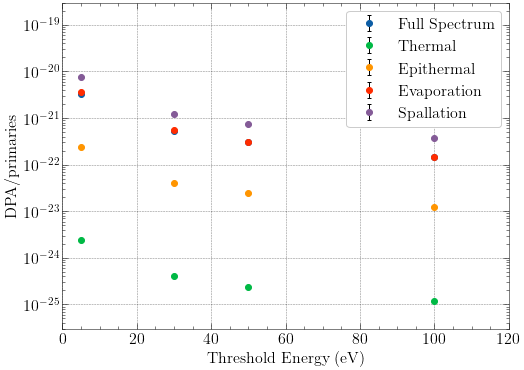

In [6]:
dataframes = [df_ful, df_the, df_epi, df_eva, df_spa]
labels = ['Full Spectrum', 'Thermal', 'Epithermal', 'Evaporation', 'Spallation']

for i in np.arange(len(dataframes)):
    plt.errorbar(dataframes[i]['E_th'],                       # x data
                 dataframes[i]['DPA'],                        # y data
                 xerr = None,                                 # Uncertainty on x values
                 yerr = dataframes[i]['abs_unc'],             # Uncertainty on y values
                 label = labels[i],
                 fmt = 'o',
                 ecolor = 'black', 
                 capsize = 2
                )
plt.xlabel('Threshold Energy (eV)')
plt.ylabel('DPA/primaries')
plt.xlim(left = 0, right = 120)
plt.ylim(bottom = 3e-26, top = 3e-19)
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('Threshold_Energy.svg', dpi=300, bbox_inches = "tight")

### Descrição
No gráfico acima, percebe-se que o DPA produzido diminui substancialmente com o aumento do limiar de energia de produção de defeitos. Note que o eixo vertical está em escala logarítmica, o que significa que o aumento linear na energia de threshold resulta na diminuição em ordens de grandeza do DPA produzido pelo número de primários simulados (10⁴ primários, neste caso). De fato, em todos os dados ocorreu ao menos a diminuição de uma ordem de grandeza ao se aumentar a energia de deslocamento de 5 eV à 100 eV. Nota-se também que nenhum dos conjuntos de dados forma um comportamento linear no gráfico logarítmico, evidenciando que a queda de produção de dano é mais acentuada do que um decaimento exponencial poderia modelar. O maior número de DPA é causado pelos nêutrons de espalação, logo em seguida vem os de evaporação que é muito similar ao dano produzido pelo espectro inteiro que é representado pelos pontos em azul abaixo dos pontos vermelhos referentes aos dados de evaporação. Estes três conjuntos de dados simulados resultaram em valores de dano entre, aproximadamente, 10⁻²⁰ e 10⁻²³ DPA's por primário. Em seguida, há os dados dos nêutrons epitérmicos que apresentam comportamento similar, porém dentro do intervalo entre 10⁻²² e 10⁻²³. Por último, há os dados referente aos danos produzidos pelos nêutrons térmicos. Estes últimos dados mostram que os nêutrons térmicos são os que produzem menos defeitos, dentro da faixa de 10⁻²⁴ e 10⁻²⁵ DPAs por primário, com valores significativamente distantes dos valores produzidos pelas partes mais energéticas do espectro.

### Explicação
A energia de threshold é a energia mínima necessária que deve ser transferida a um núcleo atômico a fim de produzir um par interstício-vacância estável. Por mais que remeta a isto, a energia de threshold não é uma energia de ligação. O núcleo atingido produzirá uma cascata de colisões nucleares binárias removendo os núcleos das suas posições de equilíbrio do retículo cristalino. Logo em seguida ocorre a recristalização e a maior parte dos núcleos voltará a ocupar uma posição de equilíbrio no cristal. Qualitativamente, quanto maior a energia de threshold, menor será o número de defeitos produzidos. Este aspecto explica o comportamento de queda das curvas. Ao mesmo tempo, nota-se que um número menor de danos é produzido pelos nêutrons menos energéticos, o que também é coerente com a física da energia de threshold. É importante notar que os danos calculados são normalizados pelo número de primários utilizado na simulação de Monte Carlo. Dessa forma, é natural que os nêutrons de espalação tenham produzido um dano maior do que a simulação envolvendo todo o espectro. Os valores de energia de threshold costumam estar entre 25 e 50 eV e o valor padrão adotado no FLUKA é de 30 eV. A finalidade destas simulações era aferir como a escolha do valor de energia afeta o cálculo final de dano. A escolha do intervalo entre 5 e 100 eV é para poder dimensionar o comportamento qualitativo de maneira confortável para além dos limites que sejam fisicamente representativos, porém evidenciando o comportamento dentro dos limites da região representativa.

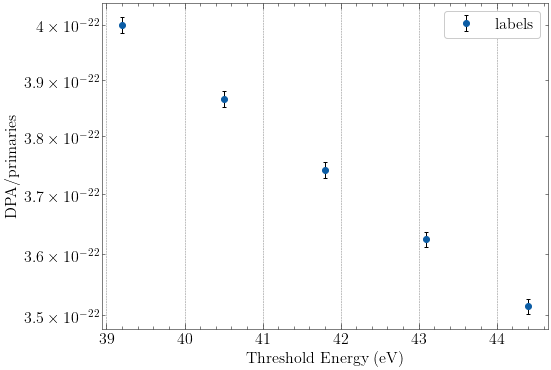

In [11]:
dataframes = df_def
plt.errorbar(dataframes['E_th'],                       # x data
             dataframes['DPA'],                        # y data
             xerr = None,                              # Uncertainty on x values
             yerr = dataframes['abs_unc'],             # Uncertainty on y values
             label = 'labels',
             fmt = 'o',
             ecolor = 'black', 
             capsize = 2
            )
plt.xlabel('Threshold Energy (eV)')
plt.ylabel('DPA/primaries')
# plt.xlim(left = 0, right = 120)
# plt.ylim(bottom = 3e-26, top = 3e-19)
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('Threshold_Energy.svg', dpi=300, bbox_inches = "tight")

,a,b
Valor,-9.281725e-24,7.628700e-22
Incerteza Absoluta,3.220370e-25,1.353163e-23
Incerteza Relativa,-3.469581e-02,1.773779e-02


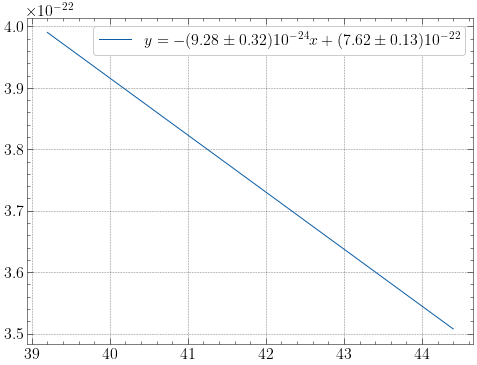

In [22]:
# Ajuste Linear

def f(x, a, b): # Função a ser ajustada
    return a*x + b

xo = [-1e-23,8e-22] # Parâmetros Iniciais
fit1 = optimization.curve_fit(f,                             # Function to be adjuscted
                              dataframes['E_th'],            # x data
                              dataframes['DPA'],             # y data
                              p0 = xo,                       # Initial guess for parameters
                              sigma = dataframes['abs_unc'], # Uncertainty on y data
                              absolute_sigma = True
                             )  
a = fit1[0][0]
b = fit1[0][1]
stdevs = np.sqrt(np.diag(fit1[1]))
σa = stdevs[0]
ua = σa/a
σb = stdevs[1]
ub = σb/b

df_fit1 = pd.DataFrame({'a' : [a, σa, ua], 
                        'b' : [b,σb, ub]
                       }, 
                       index = ['Valor', 'Incerteza Absoluta', 'Incerteza Relativa']
                     )
display(df_fit1)

x = np.linspace(dataframes['E_th'].min(), dataframes['E_th'].max(), 100)
plt.plot(x, f(x, a, b), 
         label = '$y = -(9.28 \pm 0.32)10^{-24}x + (7.62 \pm 0.13)10^{-22}$'
         #label='$y = (%5.0f \pm %5.0f)  10^{%5.0f} e^{-(%5.2f \pm %5.2f \; \mathrm{cm}^{-1}) x}$' % tuple([fman(a), fman(σa),fexp(a), b, σb]), 
         )
plt.legend()